# Week 12 - The Machine Learning Workflow

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In previous weeks we have covered preprocessing our data, dimensionality reduction, and last week looked at supervised learning. This week we will be pulling these processes together into a complete project.

Most projects can be thought of as a series of discrete steps:

* Data acquisition / loading
* Feature creation
* Feature normalization
* Feature selection
* Machine learning model
* Combining multiple models
* Reporting / Utilization


## Data acquisition

If we are fortunate our data may already be in a usable format but more often extensive work is needed to generate something usable.

* What type of data do we have?
* Do we need to combine data from multiple sources?
* Is our data structured in such a way it can be used directly?
* Does our data need to be cleaned?
* Does our data have issues with confounding?


## Feature creation

* Can our data be used directly?
* What features have been used previously for similar tasks?


## Feature normalization

* Z-score normalization?
* Min-max mormalization?


## Feature selection

The number of features we have compared with our sample size will determine whether feature selection is needed. We may choose in the first instance not to use feature selection. If we observe that our performance on the validation dataset is substantially worse than on the training dataset it is likely our model is overfitting and would benefit from limiting the number of features.

Even if the performance is comparable we may still consider using dimensionality reduction or feature selection.


## Machine learning model

Which algorithm to use will depend on the type of task and the size of the dataset. As with the preceding steps it can be difficult to predict the optimal approach and different options should be tried.


## Combining multiple models

An additional step that can frequently boost performance is combining multiple different models. It is important to consider that combining different models can make the result more difficult to interpret.

The models may be generated by simply using a different algorithm or may additionally include changes to the features used.


## Reporting / Utilization

Finally we need to be able to utilize the model we have generated. This typically takes the form of receiving a new sample and then performing all the steps used in training to make a prediction. 

If we are generating a model only to understand the structure of the data we already have the new samples may be only the test dataset we set aside at the beginning.

## Rapid experimentation

At each of the major steps we need to take there are a variety of options. It is often not clear which approach will give us the best performance and so we should try several.

Being able to rapidly try different options helps us get to the best solution faster. It is tempting to make a change to our code, execute it, look at the performance, and then decide between sticking with the change or going back to the original version. It is very easy to:

* Loose track of what code generated what solution
* Overwrite a working solution and be unable to repeat it

Using version control software is very useful for avoiding these issues.

## Optimizing the entire workflow

We have previously looked at approaches for choosing the optimal parameters for an algorithm. We also have choices earlier in the workflow that we should systematically explore - what features should we use, how should they be normalized.

Scikit learn includes functionality for easily exploring the impact of different parameters not only in the machine learning algorithm we choose but at every stage of our solution.

## Pipeline

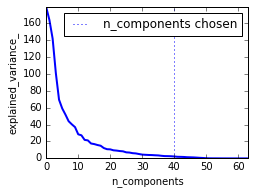

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [20, 40, 64], 'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)


In [4]:
# http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#example-plot-digits-pipe-py

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

###############################################################################
# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

###############################################################################
# Prediction

n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

print(estimator)

## FeatureUnion

In [5]:
# http://scikit-learn.org/stable/auto_examples/feature_stacker.html#example-feature-stacker-py

# Author: Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 clause

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

iris = load_iris()

X, y = iris.data, iris.target

# This dataset is way to high-dimensional. Better do PCA:
pca = PCA()

# Maybe some original features where good, too?
selection = SelectKBest()

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

# Use combined features to transform dataset:
X_features = combined_features.fit(X, y).transform(X)

svm = SVC(kernel="linear")

# Do grid search over k, n_components and C:

pipeline = Pipeline([("features", combined_features), ("svm", svm)])

param_grid = dict(features__pca__n_components=[1, 2, 3],
                  features__univ_select__k=[1, 2],
                  svm__C=[0.1, 1, 10])

grid_search = GridSearchCV(pipeline, param_grid=param_grid)
grid_search.fit(X, y)
print(grid_search.best_estimator_)

ValueError: k should be >=0, <= n_features; got 10.Use k='all' to return all features.

## Advanced Pipeline: Seizure Detection

In this example we will look at an EEG dataset with the goal of detecting the onset of epileptic seizures.

This [machine learning task and associated dataset](https://www.kaggle.com/c/seizure-detection) was put together by UPenn and Mayo Clinic and hosted on Kaggle as a competition with financial backing from NINDS and the American Epilepsy Society.

There are two parts to the data:

* 16 electrode EEG at 400 Hz from dogs with naturally occurring epilepsy
* Patient EEG recordings at 500 Hz and 5000 Hz with a variable number of electrodes

There are a number of challenges in approaching this task.

* Patient / animal specific differences
* Different number of electrodes
* Different sampling rates
* Different electrode positions
* Lack of existing features
* . . . and likely several others

### Data acquisition
Thankfully with this being a Kaggle competition the data has already been collected for us. The data has been divided into multiple files each with 1 second of data. There are training examples for each of the subjects and samples have already been chosen for the test set.

We will still want to perform validation but we can use Kaggle to measure our final performance on the test set.

### Feature creation
The data available are potentials observed by the different electrodes over the one second window used for each sample. These values are unlikely to be predictive in this format so we must use this data to create the features our model will use.

This is the first real decision we need to make. What might our features be?


### Feature normalization
Applying normalization using standard approaches may be necessary depending on the algorithm we plan to use.


### Feature selection
The dataset is reasonably large and we are likely to have a limited number of features. Our first solution might not need to select features prior to building the model.

Depending on how creative we get and how large the number of features we have grows later solutions may benefit from feature selection, either to prevent overfitting or to speed up evaluation.

### Machine learning model
Evaluating different algorithms as we build a solution is probably going to be the best approach. While we are developing features using an ensemble or boosting algorithm will be the simplest approach.

### Combining multiple models
There are multiple different levels at which we might develop machine learning models for this task. We could develop models for individual channels or all the channels combined. We could develop a single model for all subjects or separate models for each subject.

All of these different models could then be combined together.

### Reporting / Utilization
For this task we know we will have a test dataset and our performance there will be evaluated.


__NOTE:__ The dataset for this example is 43 GB uncompressed so I have not included it in the course material. If you want to run through the example it can be downloaded from the link above.

A github repository with all the code for this example is [here](https://github.com/streety/kaggle-seizure-prediction).

In [ ]:
import numpy as np
from sklearn.base import TransformerMixin


class ModelTransformer(TransformerMixin):
    """Wrap a classifier model so that it can be used in a pipeline"""
    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.predict_proba(X)

    def predict_proba(self, X, **transform_params):
        return self.transform(X, **transform_params)


class VarTransformer(TransformerMixin):
    """Compute the variance"""
    def transform(self, X, **transform_params):
        var = X.var(axis=1)
        return var.reshape((var.shape[0],1))

    def fit(self, X, y=None, **fit_params):
        return self


class MedianTransformer(TransformerMixin):
    """Compute the median"""
    def transform(self, X, **transform_params):
        median = np.median(X, axis=1)
        return median.reshape((median.shape[0],1))

    def fit(self, X, y=None, **fit_params):
        return self

class ChannelExtractor(TransformerMixin):
    """Extract a single channel for downstream processing"""
    def __init__(self, channel):
        self.channel = channel

    def transform(self, X, **transformer_params):
        return X[:,:,self.channel]

    def fit(self, X, y=None, **fit_params):
        return self


class FFTTransformer(TransformerMixin):
    """Convert to the frequency domain and then sum over bins"""
    def transform(self, X, **transformer_params):
        fft = np.fft.rfft(X, axis=1)
        fft = np.abs(fft)
        fft = np.cumsum(fft, axis=1)
        bin_size = 10
        max_freq = 60
        return np.column_stack([fft[:,i] - fft[:,i-bin_size] 
            for i in range(bin_size, max_freq, bin_size)])

    def fit(self, X, y=None, **fit_params):
        return self

In [ ]:
import numpy as np
import os
import pickle
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier

import get_traces
import transformers as trans


def build_pipeline(X):
    """Helper function to build the pipeline of feature transformations.
    We do the same thing to each channel so rather than manually copying changes
    for all channels this is automatically generated"""
    channels = X.shape[2]
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('select_%d_pipeline' % i, 
                Pipeline([('select_%d' % i, trans.ChannelExtractor(i)),
                ('channel features', FeatureUnion([
                    ('var', trans.VarTransformer()),
                    ('median', trans.MedianTransformer()),
                    ('fft', trans.FFTTransformer()),
                    ])),
                ])
            ) for i in range(channels)])),
        ('classifier', trans.ModelTransformer(RandomForestClassifier(
            n_estimators=500,
            max_depth=None,
            min_samples_split=1, 
            random_state=0))),
            ])
    return pipeline


def get_transformed_data(patient, func=get_traces.get_training_traces):
    """Load in all the data"""
    X = []
    channels = get_traces.get_num_traces(patient)
    # Reading in 43 Gb of data . . .
    for i in range(channels):
        x, y = func(patient, i)
        X.append(x)
    return (np.dstack(X), y)




all_labels = []
all_predictions = np.array([])
folders = [i for i in os.listdir(get_traces.directory) if i[0] != '.']
folders.sort()
for folder in folders:
    print('Starting %s' % folder)

    print('getting data')
    X, y = get_transformed_data(folder)
    print(X.shape)
    print('stratifiedshufflesplit')
    cv = StratifiedShuffleSplit(y,
        n_iter=5,
        test_size=0.2,
        random_state=0,)
    print('cross_val_score')
    
    pipeline = build_pipeline(X)
    
    # Putting this in a list is unnecessary for just one pipeline - use to compare multiple pipelines
    scores = [
        cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc')
        ]
    print('displaying results')
    for score, label in zip(scores, ['pipeline',]):
        print("AUC:  {:.2%} (+/- {:.2%}), {:}".format(score.mean(), 
            score.std(), label))
    
    clf = pipeline
    print('Fitting full model')
    clf.fit(X, y)
    print('Getting test data')
    testing_data, files = get_transformed_data(folder, 
            get_traces.get_testing_traces)
    print('Generating predictions')
    predictions = clf.predict_proba(testing_data)
    print(predictions.shape, len(files))
    with open('%s_randomforest_predictions.pkl' % folder, 'wb') as f:
        pickle.dump((files, predictions[:,1]), f)


## Exercises

1. Using the final example with the diabetes dataset from last week convert the solution over to a pipeline format. Do you get the same result for the optimal number of neighbors?
2. Create a new pipeline applying PCA to the dataset before the classifier. What is the optimal number of dimensions and neighbors?
3. Looking at both models do the errors correlate with the true values? This can be visualized using a Bland-Altman plot of the average plotted against the difference for the true and predicted values.
4. Build a pipeline using a different algorithm. How does this compare?
5. Finally, combine two of the pipelines you have created using a FeatureUnion and then return the average of the two models. You may need to create a transformer to do this.

(298, 10) (144, 10)


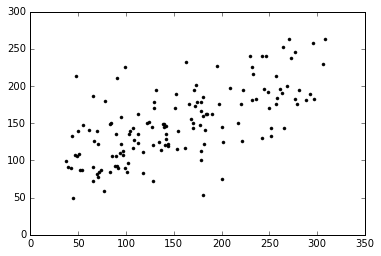

3140.59190538


{'cv': None,
 'error_score': 'raise',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': 1,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': None,
 'verbose': 0}

In [14]:
# 1 - Last week we had the following code
from sklearn import datasets, grid_search, metrics

from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

knn = neighbors.KNeighborsRegressor()

parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
clf = grid_search.GridSearchCV(knn, parameters)

clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()


print(metrics.mean_squared_error(y_test, clf.predict(X_test)))

clf.get_params()

(298, 10) (144, 10)


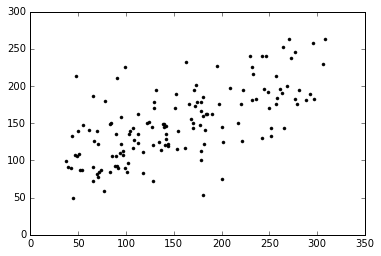

3140.59190538


{'cv': None,
 'error_score': 'raise',
 'estimator': Pipeline(steps=[('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
 'estimator__knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'estimator__knn__algorithm': 'auto',
 'estimator__knn__leaf_size': 30,
 'estimator__knn__metric': 'minkowski',
 'estimator__knn__metric_params': None,
 'estimator__knn__n_jobs': 1,
 'estimator__knn__n_neighbors': 5,
 'estimator__knn__p': 2,
 'estimator__knn__weights': 'uniform',
 'estimator__steps': [('knn',
   KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'))],
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'knn__n_neighbors': [1, 2, 

In [15]:
# 1 - This can be revised using a simple pipeline with just one element. 
#     We will expand on it later.

from sklearn import grid_search, metrics
from sklearn.pipeline import Pipeline

from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

knn = neighbors.KNeighborsRegressor()

pipeline = Pipeline([("knn", knn)])

parameters = {'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
clf = grid_search.GridSearchCV(pipeline, parameters)

clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()


print(metrics.mean_squared_error(y_test, clf.predict(X_test)))

clf.get_params()

(298, 10) (144, 10)


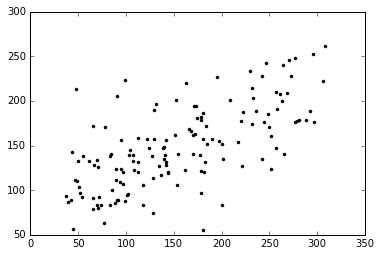

Pipeline(steps=[('pca', PCA(copy=True, n_components=8, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=9, p=2,
          weights='uniform'))])
3129.19967421


{'cv': None,
 'error_score': 'raise',
 'estimator': Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=False)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
 'estimator__knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'estimator__knn__algorithm': 'auto',
 'estimator__knn__leaf_size': 30,
 'estimator__knn__metric': 'minkowski',
 'estimator__knn__metric_params': None,
 'estimator__knn__n_jobs': 1,
 'estimator__knn__n_neighbors': 5,
 'estimator__knn__p': 2,
 'estimator__knn__weights': 'uniform',
 'estimator__pca': PCA(copy=True, n_components=None, whiten=False),
 'estimator__pca__copy': True,
 'estimator__pca__n_components': None,
 'estimator__pca__whiten': False,
 'estimator__steps': [('pca', PCA(copy=True, n_components=None,

In [16]:
# 2 - Adding PCA

from sklearn import grid_search, metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

pca = PCA()
knn = neighbors.KNeighborsRegressor()

pca_knn_pipeline = Pipeline([("pca", pca), ("knn", knn)])

parameters = {'pca__n_components':[1,2,3,4,5,6,7,8,9,10], 'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
clf = grid_search.GridSearchCV(pca_knn_pipeline, parameters)

clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()

print(clf.best_estimator_)
print(metrics.mean_squared_error(y_test, clf.predict(X_test)))

clf.get_params()

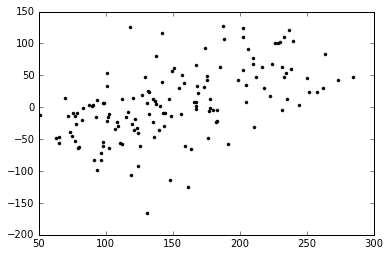

array([[ 1.       ,  0.5520988],
       [ 0.5520988,  1.       ]])

In [17]:
# 3 - Looking for bias in the predictions

plt.plot((y_test + clf.predict(X_test))/2, y_test - clf.predict(X_test), 'k.')
plt.show()

np.corrcoef((y_test + clf.predict(X_test))/2, y_test - clf.predict(X_test))

In [18]:
# 3 - There does appear to be a correlation between the magnitude of the values 
#     and the prediction errors 

(298, 10) (144, 10)


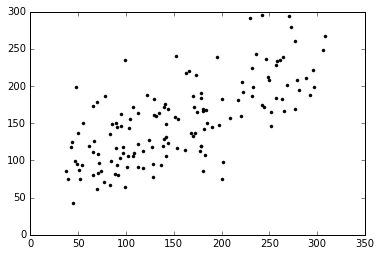

Pipeline(steps=[('linear', Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
2863.1813857
{'estimator__linear__tol': 0.001, 'refit': True, 'verbose': 0, 'error_score': 'raise', 'estimator__linear': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'estimator__linear__alpha': 1.0, 'estimator__linear__copy_X': True, 'estimator': Pipeline(steps=[('linear', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]), 'n_jobs': 1, 'estimator__linear__solver': 'auto', 'estimator__steps': [('linear', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))], 'estimator__linear__normalize': False, 'estimator__linear__max_iter': None, 'estimator__linear__fit_intercept': True, 'fit_params'

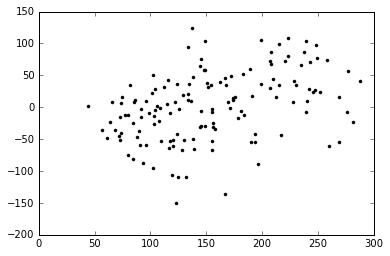

array([[ 1.        ,  0.39701591],
       [ 0.39701591,  1.        ]])

In [19]:
# 4 - Building an alternative pipeline

from sklearn import grid_search, metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn import linear_model

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)


lin = linear_model.Ridge()

linear_pipeline = Pipeline([("linear", lin)])

parameters = {'linear__alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}
clf = grid_search.GridSearchCV(linear_pipeline, parameters)

clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()

print(clf.best_estimator_)
print(metrics.mean_squared_error(y_test, clf.predict(X_test)))

print(clf.get_params())

plt.plot((y_test + clf.predict(X_test))/2, y_test - clf.predict(X_test), 'k.')
plt.show()

np.corrcoef((y_test + clf.predict(X_test))/2, y_test - clf.predict(X_test))

In [20]:
# 4 - This linear model fits the data with reduced error and shows less bias 
#     with a lower correlation between the true values and the prediction errors.